<center><img src="https://github.com/DACSS-Spatial/data_forSpatial/raw/main/logo.png" width="700"></center>

<a target="_blank" href="https://colab.research.google.com/github/DACSS-Spatial/GDF_OPS_applications/blob/main/gasandschools.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


# Moving Gas Stations away from Schools in Boston, MA

# Getting ready

## Installations needed

In [7]:
!pip install osmnx pysal

## Data collection

### Preprocessing data

I'll produce a map of Worcester (MA), the second largest city in the state. As we are going to analize schools and gas stations we must omit the water bodies. A good option is:


*   https://www.mass.gov/info-details/massgis-data-municipalities

I will select the shapefile for Worcester from there. The file returned will be a zip, which I have saved on GitHub from where I read it:



In [8]:
import geopandas as gpd

massmap="https://github.com/DACSS-Spatial-Data-Class/Homework2/raw/refs/heads/main/municipalities.zip"
massmap=gpd.read_file(massmap)
print(massmap.columns)
Worcester = massmap[massmap['town'].str.upper() == 'WORCESTER']
print("Matches:", Worcester.shape[0])
Worcester.info()

Index(['id', 'town', 'town_id', 'type', 'county', 'fips_stco', 'fourcolor',
       'pop1960', 'pop1970', 'pop1980', 'pop1990', 'pop2000', 'pop2010',
       'pop2020', 'popch10_20', 'area_acres', 'area_sqmi', 'gdb_geomattr_data',
       'geometry'],
      dtype='object')
Matches: 1
<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 1 entries, 231 to 231
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   id                 1 non-null      object  
 1   town               1 non-null      object  
 2   town_id            1 non-null      int32   
 3   type               1 non-null      object  
 4   county             1 non-null      object  
 5   fips_stco          1 non-null      int32   
 6   fourcolor          1 non-null      int32   
 7   pop1960            1 non-null      int32   
 8   pop1970            1 non-null      int32   
 9   pop1980            1 non-null      int32   
 10  pop1990          

I'll produce a map of Worcester (MA). As we are going to analize schools and gas stations we must omit the water bodies. A good option is:

* https://www.mass.gov/info-details/massgis-data-municipalities

I will select the shapefile for Worcester from there. The file returned will be a zip, which I have saved on GitHub from where I read it:

As you see, it is just one geometry:

In [9]:
Worcester

,id,town,town_id,type,county,fips_stco,fourcolor,pop1960,pop1970,pop1980,pop1990,pop2000,pop2010,pop2020,popch10_20,area_acres,area_sqmi,gdb_geomattr_data,geometry
231,GISDATA.TOWNSSURVEY_POLYM.190,WORCESTER,348,C,WORCESTER,25027,3,186587,176572,161799,169759,172648,181045,206518,25473,24602.486,38.441,None,"POLYGON ((177883.312 895676.495, 178680.013 89..."


The map we have has come projected:

In [10]:
Worcester.crs

<Projected CRS: EPSG:26986>
Name: NAD83 / Massachusetts Mainland
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - Massachusetts onshore - counties of Barnstable; Berkshire; Bristol; Essex; Franklin; Hampden; Hampshire; Middlesex; Norfolk; Plymouth; Suffolk; Worcester.
- bounds: (-73.5, 41.46, -69.86, 42.89)
Coordinate Operation:
- name: SPCS83 Massachusetts Mainland zone (meter)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

### Crowdsourced data pre processing

Now we need the schools and gas stations. Let's become familiar with OpenStreet Maps [API for Python](https://osmnx.readthedocs.io/en/stable/), which for our case would be very useful.

You can get the gas stations from Worcester like this:


In [11]:
# Get gas stations in Worcester
import osmnx as ox

gas_stations = ox.features_from_place("Worcester, Massachusetts, USA",
                                tags={'amenity': 'fuel'})

Notice we are getting several gas stations, already as a GDF:

In [12]:
gas_stations.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
MultiIndex: 39 entries, ('node', np.int64(255313595)) to ('way', np.int64(1425379657))
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   geometry              39 non-null     geometry
 1   amenity               39 non-null     object  
 2   compressed_air        3 non-null      object  
 3   addr:city             8 non-null      object  
 4   addr:housenumber      13 non-null     object  
 5   addr:postcode         7 non-null      object  
 6   addr:state            8 non-null      object  
 7   addr:street           13 non-null     object  
 8   brand                 23 non-null     object  
 9   brand:wikidata        22 non-null     object  
 10  name                  24 non-null     object  
 11  ref                   2 non-null      object  
 12  website               4 non-null      object  
 13  self_service          4 non-null      object  
 1

Add CRS coordinates to unprojected:

In [13]:
gas_stations.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Notice the multi-index:

In [14]:
gas_stations

geometry  \
element id                                                               
node    255313595                           POINT (-71.76665 42.27355)   
        255313668                           POINT (-71.76546 42.27362)   
        1214735894                           POINT (-71.7498 42.23539)   
        1309604106                          POINT (-71.83282 42.24542)   
        1310655996                          POINT (-71.80342 42.25866)   
        1310685669                          POINT (-71.81997 42.26361)   
        1310685831                          POINT (-71.81358 42.27294)   
        1534865991                          POINT (-71.79439 42.32292)   
        2575293999                           POINT (-71.78928 42.3388)   
        2584518394                          POINT (-71.75862 42.24623)   
        3751537401                             POINT (-71.8528 42.277)   
        5572302363                          POINT (-71.80888 42.25153)   
        6743220763                          POINT (-71.80638 42.29102)   
        6743220764                           POINT (-71.8066 42.29064)   
        6743220765                           POINT (-71.80728 42.2846)   
        6933076661                          POINT (-71.85267 42.27833)   
        9294992044                          POINT (-71.82047 42.26122)   
        9644018703                          POINT (-71.79825 42.25551)   
        10767363108                         POINT (-71.85226 42.27563)   
        10829838774                         POINT (-71.81001 42.24565)   
        10985421046                         POINT (-71.79617 42.21216)   
        10985885268                         POINT (-71.76256 42.22611)   
way     100227275    POLYGON ((-71.79675 42.2688, -71.79655 42.2688...   
        100227276    POLYGON ((-71.80674 42.25995, -71.8065 42.2599...   
        100492207    POLYGON ((-71.79313 42.26225, -71.79312 42.262...   
        140089097    POLYGON ((-71.79768 42.31323, -71.79748 42.313...   
        214162526    POLYGON ((-71.75245 42.2371, -71.75237 42.2371...   
        214174438    POLYGON ((-71.78033 42.29258, -71.78011 42.292...   
        214191230    POLYGON ((-71.79854 42.30893, -71.79847 42.309...   
        214195508    POLYGON ((-71.80644 42.27096, -71.80606 42.271...   
        214198813    POLYGON ((-71.81237 42.24229, -71.81236 42.242...   
        214206753    POLYGON ((-71.82077 42.24368, -71.82077 42.243...   
        214211580    POLYGON ((-71.82771 42.24399, -71.82769 42.244...   
        214225636    POLYGON ((-71.84904 42.23011, -71.84896 42.230...   
        582612243    POLYGON ((-71.80337 42.24747, -71.80246 42.247...   
        1194895532   POLYGON ((-71.83529 42.24661, -71.83523 42.246...   
        1339492241   POLYGON ((-71.7987 42.25474, -71.79855 42.2547...   
        1391712158   POLYGON ((-71.77902 42.29299, -71.77919 42.292...   
        1425379657   POLYGON ((-71.83582 42.24504, -71.83616 42.244...   

                    amenity compressed_air  addr:city addr:housenumber  \
element id                                                               
node    255313595      fuel            yes        NaN              NaN   
        255313668      fuel            yes  Worcester              312   
        1214735894     fuel            NaN        NaN              NaN   
        1309604106     fuel            NaN        NaN              NaN   
        1310655996     fuel            NaN  Worcester               48   
        1310685669     fuel            NaN        NaN              NaN   
        1310685831     fuel            NaN        NaN              NaN   
        1534865991     fuel            NaN        NaN              NaN   
        2575293999     fuel            NaN        NaN              NaN   
        2584518394     fuel            NaN        NaN              NaN   
        3751537401     fuel            NaN        NaN              NaN   
        5572302363     fuel            NaN  Worcester            

In the multi index you see **nodes** and **ways**:

In [15]:
gas_stations.index

MultiIndex([('node',   255313595),
            ('node',   255313668),
            ('node',  1214735894),
            ('node',  1309604106),
            ('node',  1310655996),
            ('node',  1310685669),
            ('node',  1310685831),
            ('node',  1534865991),
            ('node',  2575293999),
            ('node',  2584518394),
            ('node',  3751537401),
            ('node',  5572302363),
            ('node',  6743220763),
            ('node',  6743220764),
            ('node',  6743220765),
            ('node',  6933076661),
            ('node',  9294992044),
            ('node',  9644018703),
            ('node', 10767363108),
            ('node', 10829838774),
            ('node', 10985421046),
            ('node', 10985885268),
            ( 'way',   100227275),
            ( 'way',   100227276),
            ( 'way',   100492207),
            ( 'way',   140089097),
            ( 'way',   214162526),
            ( 'way',   214174438),
            ( 'way',

Some formatting may be needed at this stage:

- This will put current indexes back into the data, and numbers will appear:

In [16]:
gas_stations.reset_index(drop=False,inplace=True)
gas_stations.head()

,element,id,geometry,amenity,compressed_air,addr:city,addr:housenumber,addr:postcode,addr:state,addr:street,...,check_date,internet_access,opening_hours,payment:cash,payment:credit_cards,payment:debit_cards,phone,wheelchair,building:levels,roof:levels
0,node,255313595,POINT (-71.76665 42.27355),fuel,yes,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,node,255313668,POINT (-71.76546 42.27362),fuel,yes,Worcester,312,01604,MA,Belmont Street,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,node,1214735894,POINT (-71.7498 42.23539),fuel,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,node,1309604106,POINT (-71.83282 42.24542),fuel,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,node,1310655996,POINT (-71.80342 42.25866),fuel,NaN,Worcester,48,01608,MA,Madison Street,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- Keep some columns:

In [17]:
colsToKeep=['element','name','geometry']
fuelWorcester=gas_stations[colsToKeep].copy()

- Reproject the data:

In [18]:
fuelWorcester_crs = "EPSG:26986"
fuelWorcester = fuelWorcester.to_crs(fuelWorcester_crs)

- Review:

In [19]:
fuelWorcester.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   element   39 non-null     object  
 1   name      24 non-null     object  
 2   geometry  39 non-null     geometry
dtypes: geometry(1), object(2)
memory usage: 1.0+ KB


From above, columns **name** of the gas station has missing values. We should rename those missing values:

In [20]:
fuelWorcester.fillna({'name':'Uncertain'},inplace=True)

- Some rows have no names or have the same name which means adding name to line of code. Since several 'names' are the same (_Undisclosed_), we have to create new names:

In [21]:
fuelWorcester.index.astype(str)+"_"+fuelWorcester.name

,0
0,0_Uncertain
1,1_Speedway
2,2_Lukoil
3,3_Uncertain
4,4_Shell
5,5_Uncertain
6,6_Mobil
7,7_Shell
8,8_Shell
9,9_Stop & Shop


Then,

In [22]:
fuelWorcester['newname']=fuelWorcester.index.astype(str)+"_"+fuelWorcester.name
fuelWorcester.set_index('newname',inplace=True)
fuelWorcester.drop(columns=['name'],inplace=True)
fuelWorcester.head()

,element,geometry
newname,,
0_Uncertain,node,POINT (178003.868 891487.391)
1_Speedway,node,POINT (178101.702 891494.761)
2_Lukoil,node,POINT (179381.407 887244.327)
3_Uncertain,node,POINT (172532.859 888381.74)
4_Shell,node,POINT (174964.653 889844.182)


**nodes** are points, **ways** are lines or simple shapes built from points, and **relations** are conceptual containers that group any of the other elements to represent complex features.

Let me compare with the geometries available:


In [23]:
import pandas as pd

pd.crosstab(fuelWorcester.element,fuelWorcester.geometry.geom_type, margins=True)


col_0,Point,Polygon,All
element,,,
node,22,0,22
way,0,17,17
All,22,17,39


This is the 'relation' we have:

Let me get the schools:

In [24]:
# Get schools in Worcester
schools = ox.features_from_place("Worcester, Massachusetts, USA",
                                tags={'amenity': 'school'})
schools.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
MultiIndex: 92 entries, ('node', np.int64(257578409)) to ('way', np.int64(974861671))
Data columns (total 60 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   geometry              92 non-null     geometry
 1   addr:city             30 non-null     object  
 2   addr:housenumber      36 non-null     object  
 3   addr:postcode         30 non-null     object  
 4   addr:state            30 non-null     object  
 5   addr:street           36 non-null     object  
 6   amenity               92 non-null     object  
 7   attribution           24 non-null     object  
 8   massgis:school_id     23 non-null     object  
 9   name                  81 non-null     object  
 10  phone                 33 non-null     object  
 11  source:url            17 non-null     object  
 12  type                  26 non-null     object  
 13  grades                23 non-null     object  
 14

Let's reformat this as we did before:

In [25]:
schools.reset_index(inplace=True)
schoolWorcester=schools[['element','name','geometry']].copy()
schoolWorcester.fillna({'name':'Unknown'},inplace=True)
schoolWorcester['newname']=schoolWorcester.index.astype(str)+"_"+schoolWorcester.name
schoolWorcester.set_index('newname',inplace=True)
schoolWorcester.drop(columns=['name'],inplace=True)
schoolWorcester = schoolWorcester.to_crs(Worcester.crs)
schoolWorcester.head()

,element,geometry
newname,,
0_Central Massachusetts SPED Collaborative - Woodward Day School,node,POINT (173372.036 888142.182)
1_Burncoat Middle School,node,POINT (176183.654 894067.806)
2_Ma Academy for Math and Science School,node,POINT (175259.712 891814.014)
3_Yeshiva Hebrew Day Academy,node,POINT (173288.145 891338.811)
4_Seventh Day Adventist School,node,POINT (170663.716 891620.255)


See element vs geo:

In [26]:
pd.crosstab(schoolWorcester.element,schoolWorcester.geometry.geom_type, margins=True)

col_0,MultiPolygon,Point,Polygon,All
element,,,,
node,0,27,0,27
relation,1,0,2,3
way,0,0,62,62
All,1,27,64,92


In [27]:
#original data
schools[(schools.element=='relation') & (schools.geometry.geom_type=='MultiPolygon')]

,element,id,geometry,addr:city,addr:housenumber,addr:postcode,addr:state,addr:street,amenity,attribution,...,owner,ownership,protected,source,area,building,alt_name,religion,not:brand:wikidata,massgis:id
28,relation,15330442,"MULTIPOLYGON (((-71.79032 42.25021, -71.78971 ...",NaN,NaN,NaN,NaN,NaN,school,Office of Geographic and Environmental Informa...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47


<Axes: >

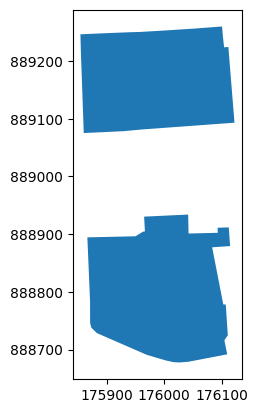

In [28]:
schoolWorcester[(schoolWorcester.element=='relation') & (schoolWorcester.geometry.geom_type=='MultiPolygon')].plot()

In [29]:
base=Worcester.explore(tiles='cartodbpositron',color='lightblue')
schoolWorcester.explore(m=base,color='k')
fuelWorcester.explore(m=base,color='red')

# Explore proximity:


Let's compute a couple of distance matrices.

- The distance among fuel stations

In [30]:
D_Matrix_fuel_fuel=fuelWorcester.geometry.apply\
(lambda station: fuelWorcester.geometry.distance(station))

D_Matrix_fuel_fuel

newname,0_Uncertain,1_Speedway,2_Lukoil,3_Uncertain,4_Shell,5_Uncertain,6_Mobil,7_Shell,8_Shell,9_Stop & Shop,...,29_Shell,30_Uncertain,31_Uncertain,32_Uncertain,33_Citgo,34_Uncertain,35_Uncertain,36_Uncertain,37_Shell,38_Uncertain
newname,,,,,,,,,,,,,,,,,,,,,
0_Uncertain,0.000000,98.111526,4461.076943,6291.025870,3454.991283,4536.013101,3872.296338,5941.735168,7484.277688,3106.444742,...,3263.873384,5103.457363,5550.354102,5999.428224,8330.825265,4113.019723,6386.495241,3341.194638,2368.993367,6522.956984
1_Speedway,98.111526,0.000000,4438.900334,6379.883644,3544.783633,4632.783406,3970.229342,5973.030659,7501.846378,3094.611169,...,3361.979018,5180.786833,5633.707556,6085.726966,8415.190772,4188.739544,6476.553185,3423.356226,2406.162937,6612.223434
2_Lukoil,4461.076943,4438.900334,0.000000,6942.356586,5125.130190,6585.175854,6715.658949,10395.040882,11939.426029,1406.929990,...,6093.037700,5192.303817,5919.720200,6487.339132,8204.709029,4535.637163,7135.718308,4561.126727,6816.853747,7153.510615
3_Uncertain,6291.025870,6379.883644,6942.356586,0.000000,2837.667554,2281.646843,3444.721552,9173.201737,10976.474153,6124.401647,...,3570.303546,1722.742861,1011.128615,449.639916,2158.678191,2440.955957,213.134362,2999.672124,6879.155144,237.546500
4_Shell,3454.991283,3544.783633,5125.130190,2837.667554,0.000000,1472.268254,1793.629338,7175.517958,8977.140301,3946.550611,...,1378.322872,1949.279229,2182.817398,2569.842980,4916.900932,1228.177686,2931.837729,564.269534,4287.603114,3068.373045
5_Uncertain,4536.013101,4632.783406,6585.175854,2281.646843,1472.268254,0.000000,1163.135193,6917.347464,8727.155663,5418.489172,...,1379.616005,2442.209350,2206.009627,2262.696946,4421.993627,2255.667683,2264.594564,2000.358135,4676.807618,2441.373866
6_Mobil,3872.296338,3970.229342,6715.658949,3444.721552,1793.629338,1163.135193,0.000000,5772.258081,7584.882910,5419.400025,...,628.750809,3398.024789,3293.944576,3411.771103,5580.439457,2951.375858,3422.272099,2341.144839,3598.505477,3600.992918
7_Shell,5941.735168,5973.030659,10395.040882,9173.201737,7175.517958,6917.347464,5772.258081,0.000000,1813.924309,9015.074853,...,5846.885317,9069.555716,9055.815324,9179.253341,11246.978101,8387.062765,9115.179012,7551.701366,3557.523185,9299.979040
8_Shell,7484.277688,7501.846378,11939.426029,10976.474153,8977.140301,8727.155663,7584.882910,1813.924309,0.000000,10589.220237,...,7657.519571,10879.560300,10869.700021,10989.657311,13036.290266,10182.729049,10913.336304,9339.879264,5158.302139,11098.598750


From here, we can compute the minimal distance among those gas stations:

In [31]:
D_Matrix_fuel_fuel.replace(0,None,inplace=True) # avoid the zero
D_Matrix_fuel_fuel.min(axis=1).sort_values().head(10)

,0
newname,
13_Uncertain,45.58439
12_Gulf,45.58439
36_Uncertain,61.067212
17_Speedway,61.067212
27_Gulf,78.4897
37_Shell,78.4897
0_Uncertain,98.111526
1_Speedway,98.111526
15_BP,148.587685


- The distance among gas stations and schools:

In [32]:
D_Matrix_fuel_school=fuelWorcester.geometry.apply\
(lambda station: schoolWorcester.geometry.distance(station))

D_Matrix_fuel_school

newname,0_Central Massachusetts SPED Collaborative - Woodward Day School,1_Burncoat Middle School,2_Ma Academy for Math and Science School,3_Yeshiva Hebrew Day Academy,4_Seventh Day Adventist School,5_Alhuda Academy,6_G Stanley Hall School/The Bridge of Central MA,7_Happy Day Child Care Ctr,8_Seven Hills Foundation,9_Saint Paul Diocesan Junior/Senior High School,...,82_Lincoln Street School,83_Nelson Place School,84_Worcester Arts Magnet School,85_Unknown,86_Unknown,87_Unknown,88_Unknown,89_Unknown,90_Unknown,91_Unknown
newname,,,,,,,,,,,,,,,,,,,,,
0_Uncertain,5713.518896,3157.802860,2763.526258,4718.063342,7341.354226,4690.449238,3065.899964,3864.856706,6752.528282,3776.281906,...,2344.528749,5009.765173,3354.360864,3505.570214,3431.662926,3467.748201,3515.235753,4828.869718,2130.574781,2039.312491
1_Speedway,5797.373339,3209.278345,2859.866091,4816.083135,7439.044745,4696.203574,3161.720584,3874.347493,6828.594069,3821.477435,...,2350.776634,5094.292063,3366.656948,3599.783017,3526.198682,3562.595993,3610.116709,4920.049524,2228.641037,2137.161337
2_Lukoil,6076.074860,7535.614654,6153.894197,7341.160705,9754.325938,9110.076985,5460.314918,1462.386333,6270.735631,2919.244563,...,6776.154279,8735.707688,7799.863851,5528.276571,5526.770011,5548.158200,5599.403932,6088.015168,5280.356874,5130.520318
3_Uncertain,872.700115,6757.192304,4383.631923,3052.003098,3739.207333,9174.438535,3367.652618,5488.695700,1671.259084,4046.441425,...,7515.119991,5384.219121,7970.370638,2843.926064,2919.167598,2854.059874,2840.923573,1457.798344,4352.688193,4310.605690
4_Shell,2330.930014,4396.016895,1991.808008,2246.017751,4653.223929,6761.983361,758.879780,3736.309181,3540.617498,2440.944023,...,4838.065081,4137.854459,5466.549172,448.074685,494.968275,479.858683,526.233215,1382.882883,1620.923577,1544.981412
5_Uncertain,2267.509935,4487.615418,2181.148353,991.195014,3180.992636,6901.464107,1483.150577,5175.386769,3610.645019,3811.401760,...,5350.695696,3313.831019,5721.812556,1111.544265,1149.003063,1086.235355,1040.048865,1029.566616,2386.006497,2395.578314
6_Mobil,3377.229532,3339.565117,1190.442042,849.030596,3473.302193,5747.263182,1257.675351,5407.258049,4722.441819,4207.242677,...,4301.178319,2369.238179,4591.883930,1314.681714,1276.277284,1222.693697,1211.376550,2122.926606,1729.426755,1781.167956
7_Shell,9146.354525,2945.124780,5186.059770,6146.994071,7376.622888,1887.902406,6417.088312,9618.944182,10488.985367,9018.767978,...,3588.286469,3661.553778,2492.547518,6807.308080,6734.910291,6714.250888,6732.307857,7893.655331,5714.653389,5749.455762
8_Shell,10959.865168,4673.492842,6985.620855,7940.372786,8996.055282,2890.730318,8218.276944,11264.556716,12302.767788,10751.069237,...,4987.717140,5381.485086,3886.849590,8615.546536,8542.292223,8522.648642,8541.497476,9706.849767,7482.556804,7512.452155


# Decision 1: Find the stations that should go away



I compute the minimal distance from a gas station to a school, and sort the stations by that value:

In [33]:
D_Matrix_fuel_school.min(axis=1).sort_values().head(10)

,0
newname,
28_Peterson's Oil Service Inc,24.826786
15_BP,100.337981
7_Shell,138.234033
23_Uncertain,146.144926
29_Shell,149.917176
31_Uncertain,160.116915
10_Tatnuck Mobil,168.374296
25_Mobil,195.916167
9_Stop & Shop,230.305123


By the previous exploration, we may decide that no station should at 150 or less from a school:

In [34]:
mindDist=150

# Decision 2: Secure perimeter of every school

Let's create the safe area around the school. This requires **buffer**:

In [35]:
schoolWorcester_buffered=schoolWorcester.buffer(mindDist)
schoolWorcester_buffered

,0
newname,
0_Central Massachusetts SPED Collaborative - Woodward Day School,"POLYGON ((173522.036 888142.182, 173521.313 88..."
1_Burncoat Middle School,"POLYGON ((176333.654 894067.806, 176332.932 89..."
2_Ma Academy for Math and Science School,"POLYGON ((175409.712 891814.014, 175408.989 89..."
3_Yeshiva Hebrew Day Academy,"POLYGON ((173438.145 891338.811, 173437.423 89..."
4_Seventh Day Adventist School,"POLYGON ((170813.716 891620.255, 170812.994 89..."
...,...
87_Unknown,"POLYGON ((174668.687 890113.785, 174653.76 890..."
88_Unknown,"POLYGON ((174830.416 890272.522, 174828.215 89..."
89_Unknown,"POLYGON ((173578.255 889203.804, 173564.614 88..."


Turning GS into GDF:

In [36]:
secured_schoolWorcester=gpd.GeoDataFrame(geometry=schoolWorcester_buffered)
secured_schoolWorcester

,geometry
newname,
0_Central Massachusetts SPED Collaborative - Woodward Day School,"POLYGON ((173522.036 888142.182, 173521.313 88..."
1_Burncoat Middle School,"POLYGON ((176333.654 894067.806, 176332.932 89..."
2_Ma Academy for Math and Science School,"POLYGON ((175409.712 891814.014, 175408.989 89..."
3_Yeshiva Hebrew Day Academy,"POLYGON ((173438.145 891338.811, 173437.423 89..."
4_Seventh Day Adventist School,"POLYGON ((170813.716 891620.255, 170812.994 89..."
...,...
87_Unknown,"POLYGON ((174668.687 890113.785, 174653.76 890..."
88_Unknown,"POLYGON ((174830.416 890272.522, 174828.215 89..."
89_Unknown,"POLYGON ((173578.255 889203.804, 173564.614 88..."


Buffers created polygons:

In [37]:
secured_schoolWorcester.geometry.geom_type.value_counts()

,count
Polygon,92


# Decision 3: Standardized Gas stations geometries

Not all gas stations are points:

In [38]:
fuelWorcester.geometry.geom_type.value_counts()

,count
Point,22
Polygon,17


The point is a simple representation. Then let's make a buffer of 10 meters for every station to make sure the station is selected even if we just had one of its points.

In [39]:
fuelWorcester_allPoly=fuelWorcester.copy()
fuelWorcester_allPoly['geometry'] = [
    station.buffer(10) if station.geom_type == 'Point' else station
    for station in fuelWorcester.geometry
]

In [40]:
# rechecking
fuelWorcester_allPoly.geometry.geom_type.value_counts()

,count
Polygon,39


# Decision 4: Overlay or SJoin to determine gas stations in trouble

This is great moment to test our understanding of these ops:

- do you want to move the points from the gas stations that are close to the schools?

In [41]:
fuelWorcester_allPoly.overlay(secured_schoolWorcester,how='intersection',keep_geom_type=False)

,element,geometry
0,node,"POLYGON ((175743.701 896977.383, 175743.557 89..."
1,node,"POLYGON ((170919.564 892043.507, 170919.42 892..."
2,way,"POLYGON ((174701.481 889988.248, 174690.619 88..."
3,way,"POLYGON ((175392.582 895448.228, 175402.483 89..."
4,way,"POLYGON ((174721.321 891202.68, 174721.317 891..."


*italicized text*- Move the gas stations that are close to the schools

In [42]:
fuelWorcester_allPoly.sjoin(secured_schoolWorcester,how='inner',predicate='intersects')

,element,geometry,newname_right
newname_left,,,
7_Shell,node,"POLYGON ((175743.749 896978.364, 175743.701 89...",81_Burncoat Street Preparatory School
15_BP,node,"POLYGON ((170919.612 892044.487, 170919.564 89...",79_Tatnuck Magnet School
23_Uncertain,way,"POLYGON ((174690.704 889988.371, 174710.58 889...",19_Saint Pauls School
28_Peterson's Oil Service Inc,way,"POLYGON ((175386.973 895426.355, 175392.582 89...",17_Greendale School
29_Shell,way,"POLYGON ((174720.387 891211.27, 174751.211 891...",59_Elm Park Community School


The obvious choice is using **sjoin** + **intersects**.

In [43]:
gas_relocate=fuelWorcester_allPoly.sjoin(secured_schoolWorcester,how='inner',predicate='intersects')



```
`# This is formatted as code`
```

The index have duplicates:

In [44]:
is_duplicate = gas_relocate.index.duplicated(keep=False)

gas_relocate[is_duplicate]

,element,geometry,newname_right
newname_left,,,


Remember our names are on the row index, then:

In [45]:
# put the index as a column: reset_index(drop=False)
# drop duplicates in that column:drop_duplicates(subset='newname_left')
# column bask to index : set_index('newname_left')

gas_relocate.reset_index(drop=False).\
drop_duplicates(subset='newname_left').\
set_index('newname_left')

,element,geometry,newname_right
newname_left,,,
7_Shell,node,"POLYGON ((175743.749 896978.364, 175743.701 89...",81_Burncoat Street Preparatory School
15_BP,node,"POLYGON ((170919.612 892044.487, 170919.564 89...",79_Tatnuck Magnet School
23_Uncertain,way,"POLYGON ((174690.704 889988.371, 174710.58 889...",19_Saint Pauls School
28_Peterson's Oil Service Inc,way,"POLYGON ((175386.973 895426.355, 175392.582 89...",17_Greendale School
29_Shell,way,"POLYGON ((174720.387 891211.27, 174751.211 891...",59_Elm Park Community School


In [46]:
#making the actual change
gas_relocate= gas_relocate.reset_index(drop=False).drop_duplicates(subset='newname_left').\
              set_index('newname_left')

Let's see both schools and those stations to relocate:

In [47]:
base=secured_schoolWorcester.sjoin(gas_relocate,how='inner',predicate='intersects').explore(color='yellow', tiles='cartodbpositron')
gas_relocate.explore(m=base,color='red')

# Decision 5: Find suitable places for the stations in trouble


We can not put the gas stations anywhere. They need to be situated on driveable routes, not inside a house or building.


- Find suitable locations along routes

Let's get the streets from Worcester with the help of OSM:

In [48]:
# Define the place
place = "Worcester, Massachusetts, USA"

# Download the street network graph for Worcester
G = ox.graph_from_place(place, network_type="drive")

# Convert the graph edges (streets) to a GeoDataFrame
streets = ox.graph_to_gdfs(G, nodes=False, edges=True)

streets.shape

(13355, 15)

You see we got a huge set of routes:

In [49]:
streets.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
MultiIndex: 13355 entries, (np.int64(64423699), np.int64(74540071), np.int64(0)) to (np.int64(13073796536), np.int64(74447788), np.int64(0))
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   osmid     13355 non-null  object  
 1   highway   13355 non-null  object  
 2   lanes     12373 non-null  object  
 3   name      12866 non-null  object  
 4   width     12204 non-null  object  
 5   oneway    13355 non-null  bool    
 6   reversed  13355 non-null  object  
 7   length    13355 non-null  float64 
 8   geometry  13355 non-null  geometry
 9   maxspeed  1394 non-null   object  
 10  ref       1080 non-null   object  
 11  tunnel    3 non-null      object  
 12  bridge    139 non-null    object  
 13  junction  72 non-null     object  
 14  access    30 non-null     object  
dtypes: bool(1), float64(1), geometry(1), object(12)
memory usage: 1.8+ MB


Let's pay attention to the 'highway' column:

In [50]:
streets.highway.value_counts().index

Index([                   'residential',                      'secondary',
                             'tertiary',                        'primary',
                                'trunk',                  'motorway_link',
                         'unclassified',                       'motorway',
                       'secondary_link',                   'primary_link',
                           'trunk_link',                  'tertiary_link',
       ['residential', 'motorway_link'],  ['unclassified', 'residential']],
      dtype='object', name='highway')

In [51]:
GAS_STATION_ROAD_TYPES = [
    'motorway',      # High-speed limited access roads
    'primary',       # Major national roads
    'trunk',         # Important regional roads
    'motorway_link', # Motorway entrance/exit ramps
    'primary_link',  # Primary road connectors
    'trunk_link',     # Trunk road connectors
    ['motorway', 'trunk'],
    ['primary', 'motorway_link'],
    ['primary', 'primary_link']
]

suitable_roads = streets[streets.highway.isin(GAS_STATION_ROAD_TYPES)]

suitable_roads.shape

(1463, 15)

Let's reproject:

In [52]:
suitable_roads = suitable_roads.to_crs(Worcester.crs)

The possible locations should be:
- Far enough from schools. They should be far from the GDF **secured_schoolWorcester** (already buffered with a secure radius) .
- Far from other Gast stations. From **fuelWorcester_allPoly** we could add a secured distance. This GDF was was buffered, but just to include the building, so we need to re buffer.

Then, we need to create a buffer around the stations:

In [53]:
competitionDistance=200 # a safe value from above 'D_Matrix_fuel_fuel'
fuelWorcester_allPoly_buffered=fuelWorcester_allPoly.buffer(competitionDistance)

Do we have a GDF?

In [54]:
secured_fuelWorcester_allPoly=gpd.GeoDataFrame(geometry=fuelWorcester_allPoly_buffered)


Let's combine the secured areas:



In [55]:
secured_areas_dissolved=secured_fuelWorcester_allPoly.overlay(secured_schoolWorcester,how='union',keep_geom_type=False).dissolve()
secured_areas=gpd.GeoDataFrame(geometry=secured_areas_dissolved.geometry)

- Filter the roads. We can NOT choose a location that intersects with the secured areas:

Choose: **overlay** vs **sjoin** vs **clip**?

<Axes: >

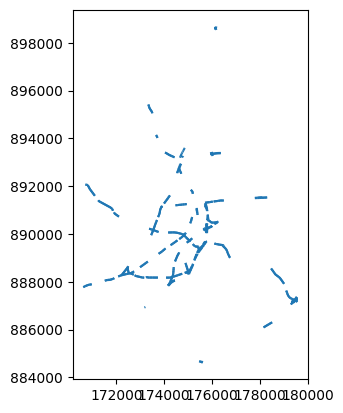

In [56]:
suitable_roads.clip(secured_areas,keep_geom_type=False).plot()

<Axes: >

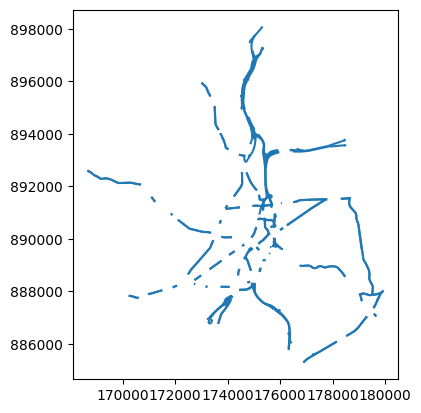

In [57]:
suitable_roads.overlay(secured_areas,keep_geom_type=False, how='difference').plot()

<Axes: >

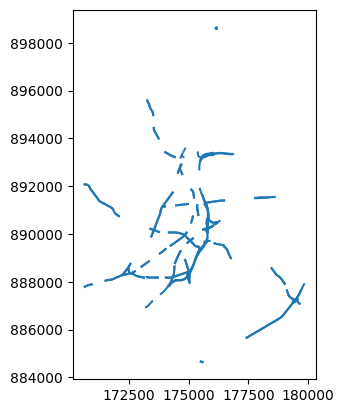

In [58]:
suitable_roads.sjoin(secured_areas, predicate='intersects').plot()

Why **clip** is a poor choice?
- Keeps only the parts that overlap with the mask. We want the opposite - to remove the overlapping parts (this would give you only roads inside school zones (the exact opposite!))

Why **sjoin** is a poor choice?
- You do get the precise locations that should not be included, you get the whole row element (more area). Since sjoin does not have a **not-intersects** predicate, this will also be wrong:

```
bad_geoms = suitable_roads.clip(secured_areas)
good_segments = suitable_roads.overlay(bad_geoms, how='difference')
```

Then:

In [59]:
good_routes_forGas_dissolved=suitable_roads.overlay(secured_areas,keep_geom_type=False, how='difference').dissolve()
good_routes_forGas=gpd.GeoDataFrame(geometry=good_routes_forGas_dissolved.geometry)
good_routes_forGas

,geometry
0,"MULTILINESTRING ((176891.069 885293.387, 17692..."


<Axes: >

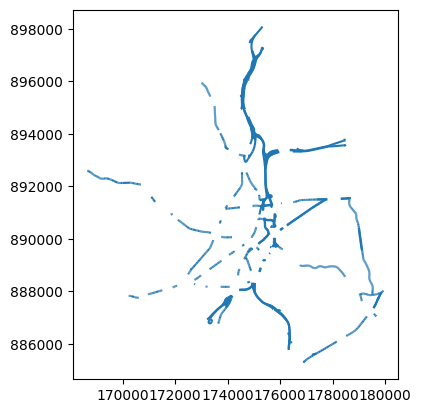

In [60]:
good_routes_forGas.plot()

We may choose a location from those places:

In [61]:
# newCOMPETITORS=safe_fuelCompetitors_gdf.copy()
potential_Locations=good_routes_forGas.copy()
newPOLYGONS=[]
pointsComputed=1
attempts=1
while pointsComputed<=len(gas_relocate):
  candidatePoint=potential_Locations.sample_points(1)
  candidateStation=gpd.GeoDataFrame(geometry=candidatePoint.buffer(100))
  if candidateStation.overlay(secured_areas,how='intersection',keep_geom_type=False).empty:
    newPOLYGONS.append(candidateStation)
    pointsComputed+=1
    potential_Locations=potential_Locations.overlay(candidateStation, how='difference', keep_geom_type=False)
  if attempts>len(gas_relocate)*10:
    break
  attempts+=1

attempts,len(newPOLYGONS)



(9, 5)

In [62]:
newPOLYGONS

[                                            geometry
 0  POLYGON ((169167.855 892355.292, 169167.374 89...,
                                             geometry
 0  POLYGON ((175582.74 892896.483, 175582.259 892...,
                                             geometry
 0  POLYGON ((175636.844 893137.936, 175636.363 89...,
                                             geometry
 0  POLYGON ((175026.797 894031.323, 175026.315 89...,
                                             geometry
 0  POLYGON ((175143.659 893626.489, 175143.178 89...]

In [63]:
pd.concat(newPOLYGONS)

,geometry
0,"POLYGON ((169167.855 892355.292, 169167.374 89..."
0,"POLYGON ((175582.74 892896.483, 175582.259 892..."
0,"POLYGON ((175636.844 893137.936, 175636.363 89..."
0,"POLYGON ((175026.797 894031.323, 175026.315 89..."
0,"POLYGON ((175143.659 893626.489, 175143.178 89..."


In [64]:
GoodLocationsGas_buffered_gdf=pd.concat(newPOLYGONS)
GoodLocationsGas_gdf=gpd.GeoDataFrame(geometry=GoodLocationsGas_buffered_gdf.centroid)

<Axes: >

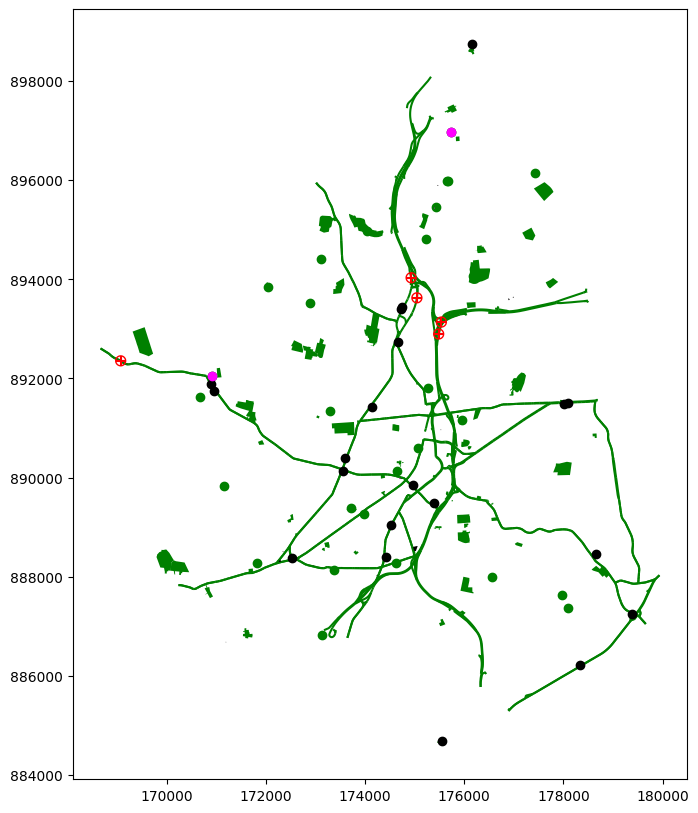

In [65]:
# Roads
base = suitable_roads.plot(color='green', figsize=(10, 10),zorder=1)

# non-overlapping buffers
GoodLocationsGas_buffered_gdf.plot(ax=base, edgecolor='red', marker="+", facecolor='none',zorder=2)

# center points of the buffers
GoodLocationsGas_gdf.plot(ax=base, color='red', marker="+", markersize=50,zorder=3)

# all stations
fuelWorcester.plot(ax=base,color='k',zorder=4)
schoolWorcester.plot(ax=base,color='green',zorder=5)

# stations to relocate
fuelWorcester.clip(gas_relocate).plot(ax=base,color='magenta',zorder=5)


## Reverse geocoding

Addresses:

In [66]:
from geopy.geocoders import Nominatim
import time

# Initialize geocoder
geolocator = Nominatim(user_agent="Worcester_gas_stations")

def get_address(point):
  # Now coordinates are in degrees (lon, lat)
  lon = point.x
  lat = point.y
  location = geolocator.reverse((lat, lon), exactly_one=True, timeout=10)
  time.sleep(1)  # Rate limiting

  if location:
    return location.address
  else:
    return None # not found

In [67]:
# Get addresses
GoodLocationsGas_4326 = GoodLocationsGas_gdf.to_crs('EPSG:4326')
geolocator = Nominatim(user_agent="Worcester_gas_stations")
GoodLocationsGas_gdf['address'] = GoodLocationsGas_4326.geometry.apply(get_address)


In [68]:
GoodLocationsGas_gdf = GoodLocationsGas_gdf.reset_index(drop=True).drop_duplicates()
GoodLocationsGas_gdf

,geometry,address
0,POINT (169067.855 892355.292),"1342, Pleasant Street, West Tatnuck, Worcester..."
1,POINT (175482.74 892896.483),"22, I 290, Brittan Square, Worcester, Worceste..."
2,POINT (175536.844 893137.936),"I 290, Brittan Square, Worcester, Worcester Co..."
3,POINT (174926.797 894031.323),"196, West Boylston Street, Chadwick Square, Wo..."
4,POINT (175043.659 893626.489),"Wright Line, 160, Gold Star Boulevard, Chadwic..."
